In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import seaborn as sns
import matplotlib.pyplot as plt

import requests
from bs4 import BeautifulSoup
import re
import string

from time import sleep
from random import randint

from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait

from transformers import pipeline

from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()


import operator




c:\Users\blash\miniconda3\envs\ML_env\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


# 데이터 수집

In [ ]:
url_list = []

for i in range(0, 3001, 30):
    url_list.append(f'https://www.tripadvisor.com/Hotels-g294197-oa{i}-Seoul-Hotels.html')

In [ ]:
reviews = []
ratings = []
stars = []
contributes = []
accessibilities = []
restaurants = []
attractions = []

In [ ]:
def review_crawl(url):
    response = requests.get(url, headers={'User-Agent': "Mozilla/5.0"})

    bsobj = BeautifulSoup(response.content,'lxml')

    links = []
    review_nums = []

    for review in bsobj.findAll('a',{'class':'review_count'}):
        review_nums.append(review.text.strip())
        a = review['href']
        a = 'https://www.tripadvisor.com'+ a
        a = a[:(a.find('Reviews')+7)] + '-or{}' + a[(a.find('Reviews')+7):]
        links.append(a)

    review_count = []
    for review_n in review_nums:
        review_n = review_n.split(' ')[0]
        review_n = int(re.sub(r"[^0-9]", "", review_n))
        review_count.append(review_n)

    for (ind, link) in enumerate(links):
        print(link)
        headers = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36'}
        page_nums = []
        for i in range(1, review_count[ind], 10):
            html2 = requests.get(link.format(i),headers=headers)
            sleep(randint(1,5))
            bsobj2 = BeautifulSoup(html2.content,'lxml')

            try:
                for r in bsobj2.findAll('a', {'class':'pageNum'}):
                    page_num = int(r.text.strip())
                    page_nums.append(page_num)
                
                access_grade = bsobj2.find('span', {'class':'iVKnd fSVJN'}).text.strip()
                restaurant = bsobj2.find('span', {'class':'iVKnd Bznmz'}).text.strip()
                attraction = bsobj2.find('span', {'class':'iVKnd rYxbA'}).text.strip()
                star = bsobj2.find('svg', {'class':'JXZuC d H0'})['aria-label'][0]
                for r in bsobj2.findAll('div', {'class':'YibKl MC R2 Gi z Z BB pBbQr'}):
                    reviews.append(r.q.span.text.strip())
                    stars.append(int(star))
                    accessibilities.append(int(access_grade))
                    restaurants.append(int(restaurant))
                    attractions.append(int(attraction))

                    rat = r.find('span', {'class':'ui_bubble_rating'})['class'][1]
                    ratings.append(rat)

                    try:
                        cont = r.find('div', {'class':'MziKN'})
                        cont = cont.find('span', {'class':'yRNgz'}).text.strip()
                    except:
                        cont = 0
                    contributes.append(int(cont))
                    

                if int(bsobj2.find('span', {'class':'pageNum current disabled'}).text.strip()) == max(page_nums):
                    break
            except:
                break
        
        print(len(reviews))


In [ ]:
for url in url_list:
    review_crawl(url)

https://www.tripadvisor.com/Hotel_Review-g294197-d12221592-Reviews-or{}-Nine_Tree_Premier_Hotel_Myeongdong_II-Seoul.html#REVIEWS
703
https://www.tripadvisor.com/Hotel_Review-g294197-d306126-Reviews-or{}-Hotel_PJ_Myeongdong-Seoul.html#REVIEWS
1456
https://www.tripadvisor.com/Hotel_Review-g294197-d306128-Reviews-or{}-Lotte_Hotel_World-Seoul.html#REVIEWS
2099
https://www.tripadvisor.com/Hotel_Review-g294197-d9452203-Reviews-or{}-Shilla_Stay_Gwanghwamun-Seoul.html#REVIEWS
2257
https://www.tripadvisor.com/Hotel_Review-g294197-d9454537-Reviews-or{}-Shilla_Stay_Guro-Seoul.html#REVIEWS
2317
https://www.tripadvisor.com/Hotel_Review-g294197-d15068651-Reviews-or{}-L_Escape_Hotel-Seoul.html#REVIEWS
2343
https://www.tripadvisor.com/Hotel_Review-g294197-d8118189-Reviews-or{}-Shilla_Stay_Mapo-Seoul.html#REVIEWS
2572
https://www.tripadvisor.com/Hotel_Review-g294197-d18185180-Reviews-or{}-Nine_Tree_Premier_Hotel_Insadong-Seoul.html#REVIEWS
2589
https://www.tripadvisor.com/Hotel_Review-g294197-d306115-R

KeyError: 'href'

In [ ]:
ratings = pd.Series(ratings).apply(lambda x: re.sub(r"[^0-9]", "",x))

In [ ]:
df = pd.DataFrame({'review':reviews, 'star':stars, 'contribute':contributes, 'accessibility':accessibilities, 'restaurant':restaurants, 'attraction':attractions, 'rating':ratings})

In [ ]:
df.to_csv('./review_1212.csv', index=0)

# 데이터 전처리

In [5]:
review_df = pd.read_csv('./review_1212.csv')

## Removal the punctuation and emoji

In [6]:
# define the punctuation and emoji to remove
punctuation = string.punctuation

emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

# remove the punctuation and emoji
def remove_punct(review_text):
    review = review_text
    trans_tab = review.maketrans("","",punctuation)
    review = review.translate(trans_tab)
    review = re.sub(emoji_pattern, "", review)
    return review


In [7]:
review_df['review'] = review_df['review'].apply(lambda x: remove_punct(x))

## Lemmatization

In [11]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_review(review):
    lemmas = [lemmatizer.lemmatize(word) for word in review.split()]
    return lemmas


In [12]:
review_df['lemmas'] = review_df['review'].apply(lambda x: lemmatize_review(x))
review_df['lemma_review'] = review_df['lemmas'].apply(lambda x: ' '.join(x)) # for sentiment analysis

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer('[\w]+')
stop_words = stopwords.words('english')
lemmatizer = nltk.stem.WordNetLemmatizer()
num_del = re.compile('[0-9]+')
review_df['review'] = review_df['review'].apply(lambda x: num_del.sub(' ', x))

texts = []
for text in review_df['review']:
    text = text.lower() # 소문자 변환
    tokens = tokenizer.tokenize(text) # 토큰화
    words = [i for i in tokens if len(i) > 2] # 2글자 이하 제거
    stopped_tokens =  [i for i in words if not i in stop_words] # 불용어 제거
    lemmas = [lemmatizer.lemmatize(i) for i in stopped_tokens] # 표제어 추출
    texts.append(lemmas)

review_df['lemmas'] = texts # for topic modeling

## Variable Processing

In [65]:
len_review = []
word_len = []
uniq_review = []

for review in review_df['lemmas'].apply(lambda x: ' '.join(x)):
    len_r = len(review)
    len_review.append(len_r)

    word_tokens = word_tokenize(review)

    result = []
    for word in word_tokens: 
        result.append(word)
    uniq_r = len(pd.Series(result).unique())
    w_len = len(result) 
    uniq_review.append(uniq_r)
    word_len.append(w_len)

review_df['length'] = len_review
review_df['word_length'] = word_len
review_df['diversity'] = uniq_review

## Sentiment Analaysis

In [9]:
emotion_classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [ ]:
anger = [] 
disgust = [] 
fear = []
joy = []
neutral = []
sadness = []
surprise = []

for ind, review in enumerate(review_df['lemma_review']):
    result = emotion_classifier(review)[0]
    anger.append(result[0]['score'])
    disgust.append(result[1]['score']) 
    fear.append(result[2]['score'])
    joy.append(result[3]['score'])
    neutral.append(result[4]['score'])
    sadness.append(result[5]['score'])
    surprise.append(result[6]['score'])

review_df['anger'] = anger
review_df['disgust'] = disgust
review_df['fear'] = fear
review_df['joy'] = joy
review_df['neutral'] = neutral
review_df['sadness'] = sadness
review_df['surprise'] = surprise

In [6]:
emotions = review_df.columns[-7:]

In [7]:
review_df['emotion_label'] = 'emotion'
max_score = review_df[emotions].max(axis=1)
for i in range(review_df.shape[0]):
    for emo in emotions:
        if review_df.iloc[i][emo] == max_score[i]:
            review_df.loc[i,'emotion_label'] = emo

In [ ]:
review_df.dropna(inplace=True)
review_df.reset_index(drop=True, inplace=True)

In [11]:
emotion_dummy = pd.get_dummies(review_df['emotion_label'])

In [14]:
df_copy = review_df[['rating', 'star', 'contribute', 'accessibility', 'restaurant', 'attraction', 'length', 'word_length', 'diversity']].copy()

In [17]:
df_new = pd.concat([df_copy, emotion_dummy], axis=1)

# Modeling

In [140]:
df_new = pd.read_csv('./model_data.csv')

In [141]:
df_new.columns

Index(['rating', 'star', 'contribute', 'accessibility', 'restaurant',
       'attraction', 'length', 'word_length', 'diversity', 'anger', 'disgust',
       'fear', 'joy', 'neutral', 'sadness', 'surprise'],
      dtype='object')

In [142]:
df_new.describe()[['star', 'contribute', 'accessibility', 'restaurant',
       'attraction', 'anger', 'disgust',
       'fear', 'joy', 'neutral', 'sadness', 'surprise', 'length', 'word_length', 'diversity', 'rating']]

star     contribute  accessibility    restaurant    attraction  \
count  68986.000000   68986.000000   68986.000000  68986.000000  68986.000000   
mean       3.654553     135.384237      94.200852    183.211188     19.857551   
std        1.073839    1214.306520      12.116334    123.169112     14.706574   
min        1.000000       0.000000      36.000000     12.000000      0.000000   
25%        3.000000       2.000000      94.000000     86.000000      7.000000   
50%        4.000000      17.000000     100.000000    150.000000     14.000000   
75%        5.000000      76.000000     100.000000    264.000000     32.000000   
max        5.000000  152092.000000     100.000000    991.000000     94.000000   

              anger       disgust          fear           joy       neutral  \
count  68986.000000  68986.000000  68986.000000  68986.000000  68986.000000   
mean       0.008886      0.010335      0.021932      0.644435      0.156684   
std        0.093846      0.101137      0.146463      0.478688      0.363505   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      1.000000      0.000000   
75%        0.000000      0.000000      0.000000      1.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

            sadness      surprise        length   word_length     diversity  \
count  68986.000000  68986.000000  68986.000000  68986.000000  68986.000000   
mean       0.056229      0.101499    318.924709     46.802525     41.222726   
std        0.230365      0.301990    138.526380     20.404386     16.953069   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000    187.000000     27.000000     25.000000   
50%        0.000000      0.000000    301.000000     44.000000     39.500000   
75%        0.000000      0.000000    460.000000     68.000000     58.000000   
max        1.000000      1.000000    761.000000    110.000000     90.000000   

             rating  
count  68986.000000  
mean      43.118169  
std        9.159622  
min       10.000000  
25%       40.000000  
50%       50.000000  
75%       50.000000  
max       50.000000

In [143]:
X_data = df_new.drop('rating', axis=1)
Y = df_new['rating']

In [144]:
X = sm.add_constant(X_data)

In [145]:
model = sm.OLS(Y,X)
results = model.fit()

In [146]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     1833.
Date:                Thu, 22 Dec 2022   Prob (F-statistic):               0.00
Time:                        11:53:43   Log-Likelihood:            -2.3977e+05
No. Observations:               68986   AIC:                         4.796e+05
Df Residuals:                   68971   BIC:                         4.797e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            29.2864      0.251    116.792      0.000      28.795      29.778
star              0.2093      0.029      7.339      0.000       0.153       0.265
contribute       -0.0001   2.46e-05     -4.279      0.000      -0.000   -5.69e-05
accessibility     0.0146      0.003      5.419      0.000       0.009       0.020
restaurant        0.0016      0.000      3.721      0.000       0.001       0.002
attraction       -0.0044      0.004     -1.228      0.219      -0.011       0.003
length            0.0258      0.002     15.610      0.000       0.023       0.029
word_length      -0.3072      0.013    -24.559      0.000      -0.332      -0.283
diversity         0.1368      0.011     13.015      0.000       0.116       0.157
anger            -4.2621      0.283    -15.037      0.000      -4.818      -3.707
disgust          -7.3031      0.264    -27.699      0.000      -7.820      -6.786
fear              6.5978      0.189     34.945      0.000       6.228       6.968
joy              14.7736      0.079    185.925      0.000      14.618      14.929
neutral           9.7412      0.097    100.717      0.000       9.552       9.931
sadness           0.9540      0.131      7.308      0.000       0.698       1.210
surprise          8.7850      0.110     79.813      0.000       8.569       9.001
==============================================================================
Omnibus:                    10406.023   Durbin-Watson:                   1.749
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19248.842
Skew:                          -0.963   Prob(JB):                         0.00
Kurtosis:                       4.728   Cond. No.                     1.45e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.93e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [147]:
vif = [variance_inflation_factor(X_data.values, i) for i in range(X_data.shape[1])]

In [148]:
vif_df = pd.DataFrame({'Variable':X_data.columns,'VIF':vif})

In [149]:
vif_df

Variable        VIF
0            star   1.058050
1      contribute   1.002987
2   accessibility   1.198479
3      restaurant   2.975508
4      attraction   3.088489
5          length  59.077019
6     word_length  73.479384
7       diversity  35.819269
8           anger   1.788926
9         disgust   1.878942
10           fear   2.913771
11            joy  56.278713
12        neutral  14.360919
13        sadness   5.856077
14       surprise  10.045081

In [150]:
X_data = X_data.drop(['word_length', 'length', 'joy', 'accessibility'], axis=1)

In [151]:
X = sm.add_constant(X_data)
model = sm.OLS(Y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     2252.
Date:                Thu, 22 Dec 2022   Prob (F-statistic):               0.00
Time:                        11:53:46   Log-Likelihood:            -2.4009e+05
No. Observations:               68986   AIC:                         4.802e+05
Df Residuals:                   68974   BIC:                         4.803e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         45.6107      0.140    326.278      0.000      45.337      45.885
star           0.2373      0.028      8.356      0.000       0.182       0.293
contribute    -0.0001   2.47e-05     -4.288      0.000      -0.000   -5.74e-05
restaurant     0.0014      0.000      3.378      0.001       0.001       0.002
attraction     0.0021      0.004      0.595      0.552      -0.005       0.009
diversity     -0.0195      0.002    -10.828      0.000      -0.023      -0.016
anger        -19.3314      0.320    -60.440      0.000     -19.958     -18.705
disgust      -22.4753      0.297    -75.679      0.000     -23.057     -21.893
fear          -8.2990      0.206    -40.300      0.000      -8.703      -7.895
neutral       -5.2935      0.085    -62.521      0.000      -5.459      -5.128
sadness      -14.0928      0.132   -106.820      0.000     -14.351     -13.834
surprise      -6.2342      0.103    -60.771      0.000      -6.435      -6.033
==============================================================================
Omnibus:                    10731.666   Durbin-Watson:                   1.743
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20189.301
Skew:                          -0.982   Prob(JB):                         0.00
Kurtosis:                       4.780   Cond. No.                     1.31e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.31e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [152]:
vif = [variance_inflation_factor(X_data.values, i) for i in range(X_data.shape[1])]
vif_df = pd.DataFrame({'Variable':X_data.columns,'VIF':vif})
vif_df

Variable       VIF
0         star  5.642939
1   contribute  1.015117
2   restaurant  9.408423
3   attraction  8.260219
4    diversity  5.442164
5        anger  1.015740
6      disgust  1.016535
7         fear  1.038748
8      neutral  1.233216
9      sadness  1.092934
10    surprise  1.193029

# Analysis

## topic modeling (LDA)

In [6]:
neg_documents = review_df.loc[review_df['rating'] <= 30]['lemmas'].copy()
pos_documents = review_df.loc[review_df['rating'] > 30]['lemmas'].copy()

In [7]:
def lda_topic_n(documents):
    '''
    적절한 토픽 수 확인을 위한 주제 일관성, 혼란도 시각화
    '''
    dictionary = corpora.Dictionary(documents) # 단어사전
    corpus = [dictionary.doc2bow(text) for text in documents] # bag of words 변환

    coherence_values=[] # 주제 일관성
    perplexity_values =[] # 혼란도
    for i in range(2,20): 
        ldamodel=LdaModel(corpus, num_topics=i, id2word=dictionary)
        perplexity_values.append(ldamodel.log_perplexity(corpus))
        coherence_model_lda =CoherenceModel(model=ldamodel, texts=documents, dictionary = dictionary, topn=10)
        coherence_lda=coherence_model_lda.get_coherence()
        coherence_values.append(coherence_lda)

    x=range(2,20)
    plt.plot(x,coherence_values)
    plt.xlabel("number of topics")
    plt.ylabel("coherence score")
    plt.show()

    plt.plot(x,perplexity_values)
    plt.xlabel('number of topics')
    plt.ylabel('perplexity score')
    plt.show()

In [8]:
def check_topics(documents, n_topics):
    '''
    토픽별 주요 단어 확인
    '''
    dictionary = corpora.Dictionary(documents) # 단어사전
    corpus = [dictionary.doc2bow(text) for text in documents] # bag of words 변환

    NUM_TOPICS = n_topics # 토픽 수
    ldamodel = LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary)
    # 토픽별로 주요 단어 확인
    topics = ldamodel.print_topics(num_words=10)
    for topic in topics:
        print(topic)
    
    return ldamodel, corpus, dictionary, topics

### Negative (rating <=30) 토픽 모델링

In [42]:
lda_topic_n(neg_documents)

In [44]:
neg_lda, neg_corpus, neg_dict, neg_topics = check_topics(neg_documents, 10)
gensimvis.prepare(neg_lda, neg_corpus, neg_dict)

(0, '0.029*"room" + 0.023*"hotel" + 0.019*"location" + 0.017*"good" + 0.012*"small" + 0.011*"area" + 0.011*"station" + 0.011*"walk" + 0.010*"bed" + 0.009*"myeongdong"')
(1, '0.029*"room" + 0.020*"hotel" + 0.015*"staff" + 0.010*"day" + 0.010*"night" + 0.008*"stay" + 0.008*"front" + 0.007*"one" + 0.007*"desk" + 0.007*"stayed"')
(2, '0.039*"hotel" + 0.029*"room" + 0.013*"station" + 0.010*"seoul" + 0.010*"good" + 0.009*"location" + 0.009*"walk" + 0.008*"airport" + 0.008*"bus" + 0.008*"night"')
(3, '0.053*"room" + 0.014*"hotel" + 0.012*"night" + 0.012*"floor" + 0.011*"told" + 0.008*"one" + 0.007*"window" + 0.006*"hot" + 0.006*"got" + 0.006*"front"')
(4, '0.012*"hotel" + 0.011*"serviced" + 0.011*"room" + 0.006*"day" + 0.006*"pool" + 0.005*"kitchenette" + 0.005*"lounge" + 0.005*"staff" + 0.005*"suck" + 0.005*"chicken"')
(5, '0.057*"room" + 0.019*"bed" + 0.018*"hotel" + 0.013*"small" + 0.011*"bathroom" + 0.009*"one" + 0.009*"clean" + 0.009*"good" + 0.009*"guesthouse" + 0.008*"night"')
(6, '0.0

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.067861  0.027638       1        1  26.432023
6      0.060954  0.031176       2        1  18.149698
5      0.072910 -0.009427       3        1  13.898758
1      0.020607 -0.052111       4        1  13.348080
8     -0.019143 -0.072104       5        1   8.927324
0      0.079739  0.092938       6        1   6.672408
3     -0.020267 -0.092677       7        1   6.433807
7     -0.021897 -0.061280       8        1   4.035856
9     -0.074141  0.093098       9        1   1.258821
4     -0.166623  0.042752      10        1   0.843226, topic_info=          Term          Freq         Total Category  logprob  loglift
40        room  17625.000000  17625.000000  Default  30.0000  30.0000
17       hotel  13422.000000  13422.000000  Default  29.0000  29.0000
202  breakfast   3111.000000   3111.000000  Default  28.0000  28.0000
127       good   4703.000000   4703.000000  Default  27.0000  27.0000
47     station   2716.000000   2716.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
99        stay     15.657892   3560.514868  Topic10  -5.6423  -0.6510
318      seoul     15.301653   2797.618710  Topic10  -5.6654  -0.4329
649        use     13.672528    844.837187  Topic10  -5.7779   0.6519
80       first     14.048561   1709.501088  Topic10  -5.7508  -0.0257
202  breakfast     13.949102   3111.341879  Topic10  -5.7579  -0.6317

[830 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
5903      9  0.756656  abrupt
5665      4  0.964458     abt
6000      1  0.053434  accept
6000      2  0.040075  accept
6000      3  0.133585  accept
...     ...       ...     ...
1007      5  0.038324   youre
1007      6  0.025550   youre
1007      7  0.054293   youre
1007      8  0.006387   youre
1007     10  0.003194   youre

[2663 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 6, 2, 9, 1, 4, 8, 10, 5])

### Positive (rating > 30) 토픽 모델링

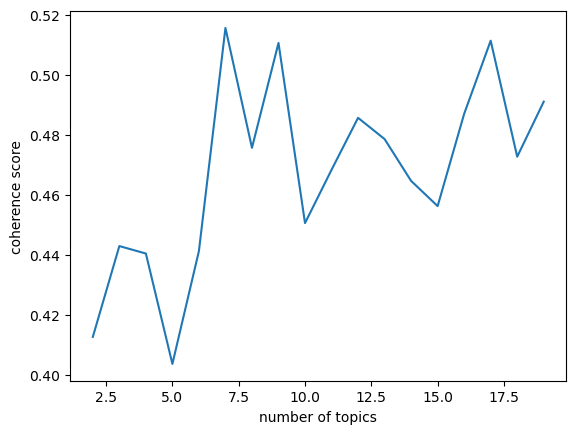

In [38]:
lda_topic_n(pos_documents)

In [46]:
pos_lda, pos_corpus, pos_dict, pos_topics = check_topics(pos_documents, 7)
gensimvis.prepare(pos_lda, pos_corpus, pos_dict)

(0, '0.026*"stay" + 0.020*"seoul" + 0.018*"time" + 0.017*"hotel" + 0.017*"staff" + 0.016*"place" + 0.011*"korea" + 0.011*"really" + 0.010*"back" + 0.010*"friend"')
(1, '0.024*"room" + 0.017*"hotel" + 0.013*"well" + 0.011*"check" + 0.010*"breakfast" + 0.009*"early" + 0.009*"arrived" + 0.008*"night" + 0.007*"stayed" + 0.007*"morning"')
(2, '0.020*"lounge" + 0.017*"room" + 0.017*"hotel" + 0.015*"breakfast" + 0.014*"club" + 0.014*"floor" + 0.010*"sheraton" + 0.010*"service" + 0.009*"executive" + 0.009*"view"')
(3, '0.039*"hostel" + 0.028*"room" + 0.019*"bathroom" + 0.017*"owner" + 0.014*"breakfast" + 0.014*"bed" + 0.014*"shower" + 0.013*"floor" + 0.012*"one" + 0.010*"coffee"')
(4, '0.044*"room" + 0.019*"guesthouse" + 0.018*"good" + 0.016*"staff" + 0.014*"clean" + 0.013*"hotel" + 0.011*"nice" + 0.010*"night" + 0.010*"stay" + 0.009*"really"')
(5, '0.032*"hotel" + 0.031*"station" + 0.022*"walk" + 0.021*"room" + 0.018*"subway" + 0.016*"airport" + 0.015*"bus" + 0.013*"location" + 0.012*"minute"

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.021344  0.196214       1        1  23.618124
4      0.010042  0.037175       2        1  21.460131
6      0.081206  0.063685       3        1  20.402625
0      0.178325 -0.057149       4        1  13.571060
3     -0.241541  0.027253       5        1   7.445970
1     -0.015622 -0.109062       6        1   7.420908
2     -0.033754 -0.158117       7        1   6.081182, topic_info=            Term          Freq         Total Category  logprob  loglift
9075      hostel   7950.000000   7950.000000  Default  30.0000  30.0000
168      station  23702.000000  23702.000000  Default  29.0000  29.0000
4072  guesthouse  11113.000000  11113.000000  Default  28.0000  28.0000
28          room  60993.000000  60993.000000  Default  27.0000  27.0000
127         walk  16040.000000  16040.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
29          stay    842.438279  26591.510094   Topic7  -5.2738  -0.6521
48          nice    775.012361  18618.224672   Topic7  -5.3572  -0.3790
65           day    721.198312  10718.181380   Topic7  -5.4292   0.1012
34          well    714.907749  12731.916642   Topic7  -5.4379  -0.0797
133        night    727.369677  17172.839525   Topic7  -5.4206  -0.3617

[609 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
720        1  0.307616  access
720        2  0.063209  access
720        3  0.359387  access
720        4  0.005719  access
720        5  0.013846  access
...      ...       ...     ...
6109       7  0.988713  yogurt
19415      4  0.985253     yoo
1016       4  0.989176    yoon
15254      1  0.993245     องน
15944      5  0.990604     องพ

[1836 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 7, 1, 4, 2, 3])